<a href="https://colab.research.google.com/github/zhengweiyu/Awesome-WAF/blob/master/TrendFollowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
# 导入必要的库
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
from datetime import datetime  # Add this import


In [ ]:
class TrendFollowingStrategy(bt.Strategy):
    params = (
        ("long_period", 200),
        ("position_percent", 80),
        ("slippage_percent", 0.5),
        ("noise_filter_percent", 0.01),
    )

    def __init__(self):
        self.ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_period)

    def log(self, text, dt=None):
        dt = dt or self.data.datetime.date(0)
        print(f"{dt.isoformat()}, {text}")

    def should_execute_trade(self):
        # Execute trade only when price deviation from the long-term moving average exceeds the noise filter percentage
        return abs((self.data.close[0] - self.ma[0]) / self.ma[0]) > self.params.noise_filter_percent

    def execute_buy_signal(self):
        # Calculate position size based on available capital
        investment_amount = (self.params.position_percent / 100) * self.broker.getvalue()
        position_size = int(investment_amount / self.data.close[0])

        # Calculate slippage
        slippage = self.data.close[0] * self.params.slippage_percent / 100
        buy_price = self.data.close[0] + slippage

        self.log(f"Buy signal triggered - Buy price: {buy_price:.2f}")
        self.buy(size=position_size, price=buy_price)

    def execute_sell_signal(self):
        self.log(f"Sell signal triggered - Sell price: {self.data.close[0]:.2f}")
        self.close()

    def next(self):
        if not self.position and self.data.close[0] > self.ma[0] and self.should_execute_trade():
            self.execute_buy_signal()
        elif self.position and self.data.close[0] < self.ma[0] and self.should_execute_trade():
            self.execute_sell_signal()

In [ ]:
def plot_results(cerebro):
    # 设置图表大小
    plt.rcParams['figure.figsize'] = [12, 8]

    # 将横轴加上时间
    cerebro.plot(iplot=False, fmt_x_data=True)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [ ]:
def load_and_prepare_data(symbol, start_date, end_date):
    # Download data from Yahoo Finance
    data = yf.download(symbol, start=start_date, end=end_date)

    # Convert the Series to a DataFrame
    data = pd.DataFrame(data)

    # Handle NaN values in the data
    data.dropna(inplace=True)

    # Add data feed
    feed = bt.feeds.PandasData(dataname=data)

    return feed

In [ ]:
def main():
    # 初始化数据
    symbol = "KWEB"
    start_date = "2019-01-01"
    end_date = "2023-12-31"
    feed = load_and_prepare_data(symbol, start_date, end_date)

    # 创建Cerebro实例
    cerebro = bt.Cerebro()

    # 添加策略
    cerebro.addstrategy(TrendFollowingStrategy)

    # 添加数据到Cerebro
    cerebro.adddata(feed, name='ETF')

    # 设置初始资金
    cerebro.broker.setcash(10000.0)

    # 打印初始条件
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测
    cerebro.run()

    # 绘制结果
    plot_results(cerebro)


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2019-10-25, Buy signal triggered - Buy price: 45.06
2020-03-12, Sell signal triggered - Sell price: 43.36
2020-03-26, Buy signal triggered - Buy price: 46.68
2020-03-27, Sell signal triggered - Sell price: 44.16
2020-04-07, Buy signal triggered - Buy price: 46.73
2021-03-29, Sell signal triggered - Sell price: 74.37
2021-03-31, Buy signal triggered - Buy price: 76.73
2021-04-12, Sell signal triggered - Sell price: 74.96
2021-04-23, Buy signal triggered - Buy price: 78.17
2021-04-30, Sell signal triggered - Sell price: 75.14
2022-11-30, Buy signal triggered - Buy price: 28.55
2023-03-09, Sell signal triggered - Sell price: 28.11
2023-03-23, Buy signal triggered - Buy price: 30.46
2023-04-21, Sell signal triggered - Sell price: 28.31
2023-06-14, Buy signal triggered - Buy price: 29.40
2023-06-20, Sell signal triggered - Sell price: 27.84
2023-07-12, Buy signal triggered - Buy price: 29

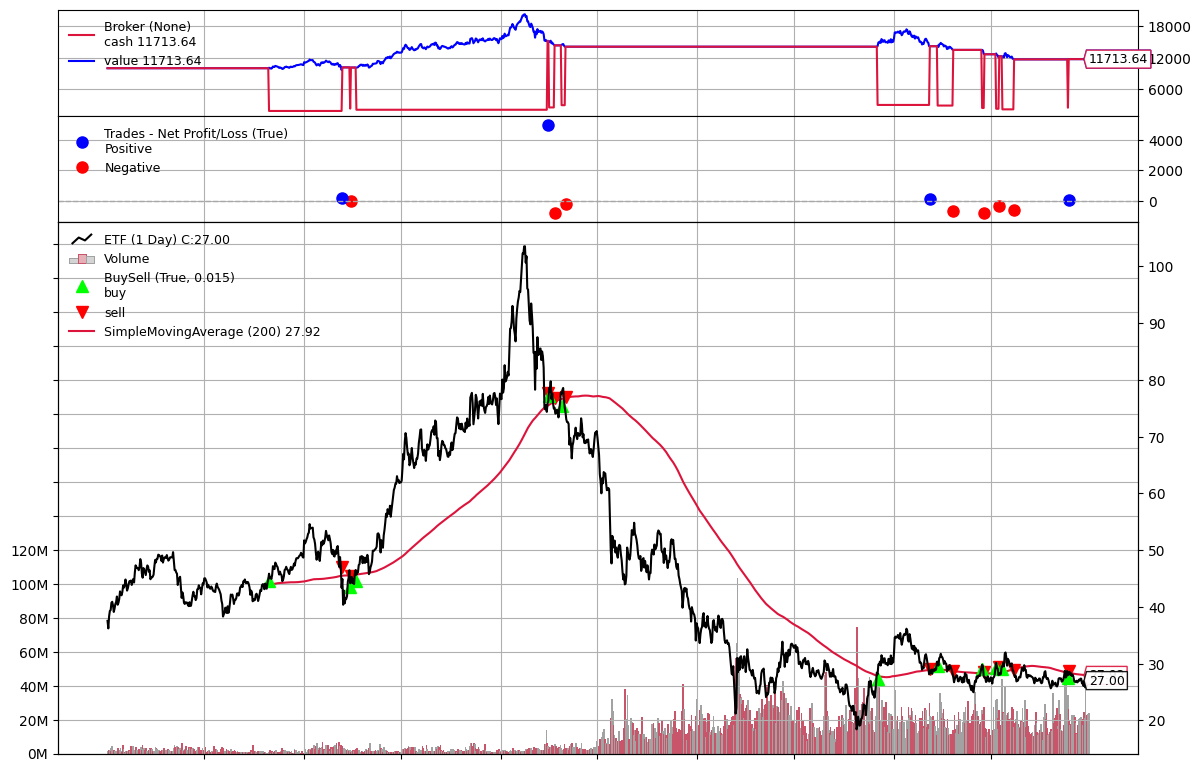

Final Portfolio Value: 11713.64


In [ ]:
if __name__ == '__main__':
  main()